In [1]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from collections import defaultdict

from config import recent_play_by_play, recent_clean_db, last_game_date, tourney_bubble


In [2]:
## File Paths
folder_prefix = ''

data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path

#### Database connection and extract 

In [3]:
## Load the database
conn = sqlite3.connect(recent_clean_db, isolation_level=None)

## Extract player_stats and convert TOI into seconds for easier calculations
player_stats = pd.read_sql_query("SELECT * FROM player_stats", conn)

### TOI to seconds - From MM:SS string to seconds integer
def convert_toi_to_seconds(toi_str):
    if pd.isna(toi_str):
        return None
    try:
        minutes, seconds = map(int, toi_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return None

player_stats['TOI'] = player_stats['TOI'].apply(convert_toi_to_seconds)

# Check Data
print(player_stats.head())


             Team           Player  G  A Pts plus_minus Sh     TOI PIM  FOW  \
0  Michigan State     Isaac Howard  1  1   2          2  5  1034.0   0  NaN   
1  Michigan State   Daniel Russell  1  1   2          2  5  1140.0   0  0.0   
2  Michigan State    Nathan Mackie  0  0   0          0  1   414.0   2  2.0   
3  Michigan State   Shane Vansaghi  0  0   0          0  0   580.0   0  NaN   
4  Michigan State  Gavin O'Connell  0  0   0         -1  2   948.0   0  NaN   

   FOL   FO%                                  Game_ID  
0  NaN   NaN  2024-10-04-Michigan State-Lake Superior  
1  1.0   0.0  2024-10-04-Michigan State-Lake Superior  
2  3.0  40.0  2024-10-04-Michigan State-Lake Superior  
3  NaN   NaN  2024-10-04-Michigan State-Lake Superior  
4  NaN   NaN  2024-10-04-Michigan State-Lake Superior  


In [4]:
#### Create a date column for each row based on the Game_ID to track change in ice time over the season
def get_date_from_game_id(game_id):
    if pd.isna(game_id):
        return None
    try:
        return str(game_id)[:10]

        # Convert to datetime object
        date_obj = datetime.strptime(game_id, '%Y-%m-%d')
        # Convert to desired format
        

    except ValueError:
        return None

# Create a new column 'Date' in the DataFrame
player_stats['Date'] = player_stats['Game_ID'].apply(get_date_from_game_id)

# Check Data
print(player_stats.head())

             Team           Player  G  A Pts plus_minus Sh     TOI PIM  FOW  \
0  Michigan State     Isaac Howard  1  1   2          2  5  1034.0   0  NaN   
1  Michigan State   Daniel Russell  1  1   2          2  5  1140.0   0  0.0   
2  Michigan State    Nathan Mackie  0  0   0          0  1   414.0   2  2.0   
3  Michigan State   Shane Vansaghi  0  0   0          0  0   580.0   0  NaN   
4  Michigan State  Gavin O'Connell  0  0   0         -1  2   948.0   0  NaN   

   FOL   FO%                                  Game_ID        Date  
0  NaN   NaN  2024-10-04-Michigan State-Lake Superior  2024-10-04  
1  1.0   0.0  2024-10-04-Michigan State-Lake Superior  2024-10-04  
2  3.0  40.0  2024-10-04-Michigan State-Lake Superior  2024-10-04  
3  NaN   NaN  2024-10-04-Michigan State-Lake Superior  2024-10-04  
4  NaN   NaN  2024-10-04-Michigan State-Lake Superior  2024-10-04  


## Time On Ice Exploration

- WANT TO DO
    - Get Line and position for each player for each game - link by game_id can also pull in shot and whatever other data might want (blocked shots)

In [5]:
### Call the line_chart db table to the a dataframe
line_chart = pd.read_sql_query("SELECT * FROM line_chart", conn)

# Group into F / D / G lines based on Position column into new pos_1 / pos_2 columns
# # pos_1 = F / D / G 
# Center, Left Wing, Right Wing = F
# left D, Right D = D
# Goalie = G

# pos_2 = C / L / R / D / G


## Assign positions in the new columns
def assign_positions(row):
    if row['Position'] in ['Center', 'Left Wing', 'Right Wing']:
        return pd.Series(['F', row['Position'][0]])
    elif row['Position'] in ['Left D', 'Right D']:
        return pd.Series(['D', 'D'])
    elif row['Position'] == 'Goalie':
        return pd.Series(['G', 'G'])
    else:
        return pd.Series([None, None])
line_chart[['pos_1', 'pos_2']] = line_chart.apply(assign_positions, axis=1)









# Check Data
print(line_chart.head(20))



             Team      Line    Position             Player  \
0   Lake Superior         1   Left Wing    Sasha Teleguine   
1   Lake Superior         1      Center         Timo Bakos   
2   Lake Superior         1  Right Wing    Jordan Venegoni   
3   Lake Superior         2   Left Wing   Luke Levandowski   
4   Lake Superior         2      Center    John Herrington   
5   Lake Superior         2  Right Wing       Branden Piku   
6   Lake Superior         3   Left Wing     Blake Humphrey   
7   Lake Superior         3      Center     Connor Milburn   
8   Lake Superior         3  Right Wing       Dawson Tritt   
9   Lake Superior         4   Left Wing     Reagan Milburn   
10  Lake Superior         4      Center     William Ahlrik   
11  Lake Superior         4  Right Wing  Wilson Dahlheimer   
12  Lake Superior         1      Left D         Evan Bushy   
13  Lake Superior         1     Right D    Nate Schweitzer   
14  Lake Superior         2      Left D      Grant Hindman   
15  Lake

In [6]:
#### Merge Position Data in with the player_stats dataframe based on Team, Player, and Game_ID

merged_df = pd.merge(player_stats, line_chart[['Game_ID', 'Team', 'Player', 'Line', 'pos_1', 'pos_2']], on=['Game_ID', 'Team', 'Player'], how='left')

# Relabel the rows of extra skaters - they have NaN in Line pos1 / pos_2 columns - Replace with 'E'
# merged_df.loc[merged_df['pos_1'].isna(), 'pos_1'] = 'E'
# merged_df.loc[merged_df['pos_2'].isna(), 'pos_2'] = 'E'
merged_df['pos_1'].fillna('E', inplace=True)
merged_df['pos_2'].fillna('E', inplace=True)
merged_df['Line'].fillna('E', inplace=True)

# Remove any rows with TOI = 0
merged_df = merged_df[merged_df['TOI'] != 0]


# Check Data
# merged_df.head(20)

C:\Users\jbanc\AppData\Local\Temp\ipykernel_20852\2423493902.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['pos_1'].fillna('E', inplace=True)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_20852\2423493902.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [7]:
### Some Basic statitical exploration

# ### Calculate mean and median TOI for forwards and defense by team
def calculate_mean_median_toi(player_stats):
    # Group by team and position
    grouped = player_stats.groupby(['Team', 'pos_1'])

    # Calculate mean and median TOI
    mean_toi = grouped['TOI'].mean()
    median_toi = grouped['TOI'].median()

    return pd.DataFrame({'Mean_TOI': mean_toi, 'Median_TOI': median_toi}).reset_index()

mean_median_df = calculate_mean_median_toi(merged_df)

# Drop G rows
mean_median_df = mean_median_df[mean_median_df['pos_1'] != 'G']


# Check Data
mean_median_df.head()
mean_median_df.tail()
# mean_median_df.info()
# mean_median_df.describe()

,Team,pos_1,Mean_TOI,Median_TOI
249,Wisconsin,E,449.342105,454.0
250,Wisconsin,F,885.426316,878.0
252,Yale,D,1133.277027,1144.0
253,Yale,E,392.904762,378.0
254,Yale,F,894.892617,939.0


### Calculate mean, median based on Line and Position

In [8]:
#### Get the mean and median TOI for each team grouped by line and pos_1

def calculate_mean_median_toi_by_line(player_stats):
    # Group by team, line, and position
    grouped = player_stats.groupby(['Team', 'Line', 'pos_1'])

    # Calculate mean and median TOI
    mean_toi = grouped['TOI'].mean()
    median_toi = grouped['TOI'].median()

    return pd.DataFrame({'Mean_TOI': mean_toi, 'Median_TOI': median_toi}).reset_index()

mean_median_by_line_df = calculate_mean_median_toi_by_line(merged_df)

# Drop G rows
mean_median_by_line_df = mean_median_by_line_df[mean_median_by_line_df['pos_1'] != 'G']

# Check Data
mean_median_by_line_df.head()

# Info
# mean_median_by_line_df.info()

# 

,Team,Line,pos_1,Mean_TOI,Median_TOI
0,Air Force,1,D,1335.073529,1348.0
1,Air Force,1,F,1106.474747,1120.0
2,Air Force,2,D,1183.696970,1226.0
3,Air Force,2,F,994.131313,1016.0
4,Air Force,3,D,833.825397,853.0


#### Quick Histogram off TOI by F / D

c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\d

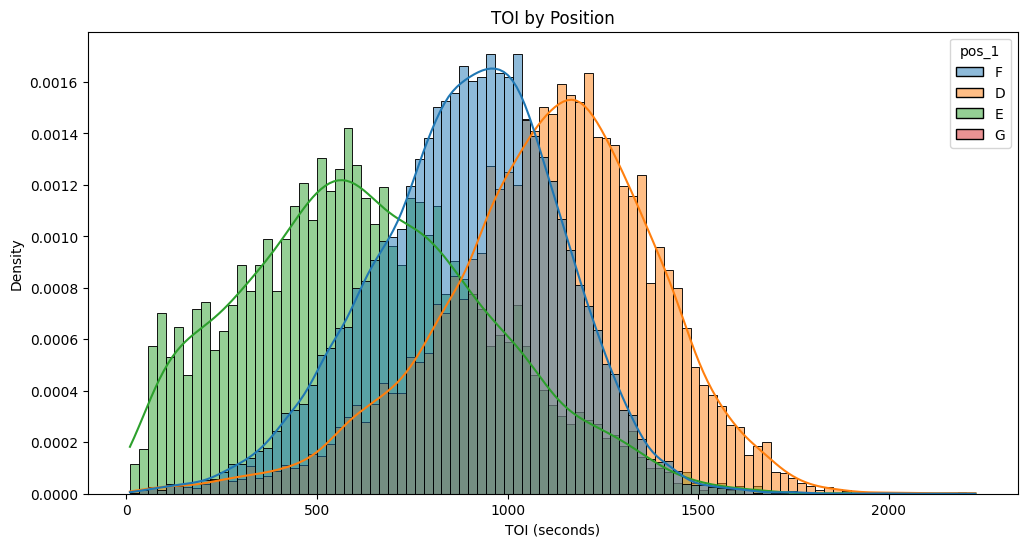

In [9]:
### Eaxamine the data with hisotgrams of TOI by position
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for TOI by position
sns.histplot(data=merged_df, x='TOI', hue='pos_1', kde=True, stat='density', common_norm=False)
# Set the title and labels
plt.title('TOI by Position')
plt.xlabel('TOI (seconds)')
plt.ylabel('Density')
# Show the plot
plt.show()


#### Quick Hosoptgram of TOI Forwards Only on Line assignment

c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\d

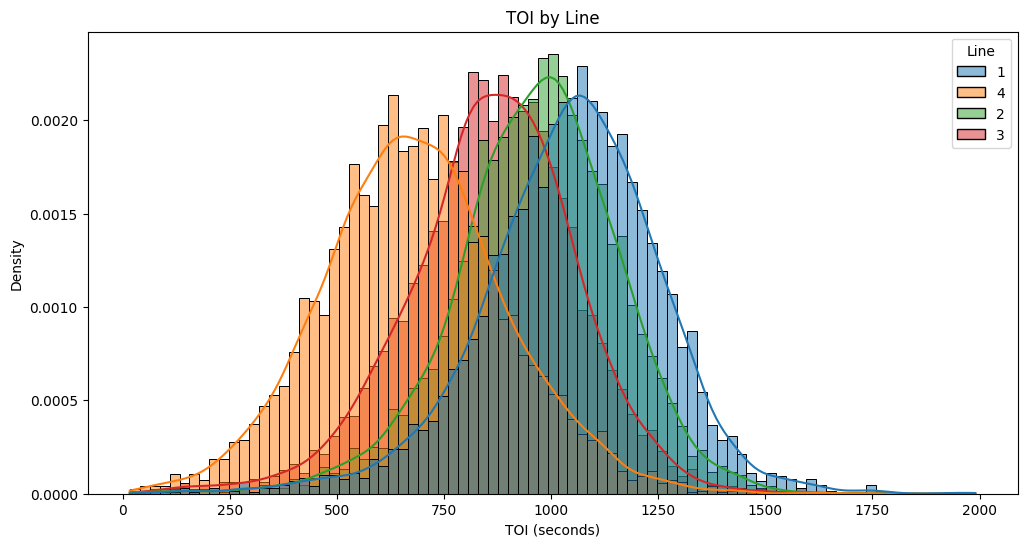

In [10]:
### Same thing by line - only forwards

# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for TOI by position
sns.histplot(data=merged_df[merged_df['pos_1'] == 'F'], x='TOI', hue='Line', kde=True, stat='density', common_norm=False)
# Set the title and labels
plt.title('TOI by Line')
plt.xlabel('TOI (seconds)')
plt.ylabel('Density')
# Show the plot
plt.show()
# Set the figure size

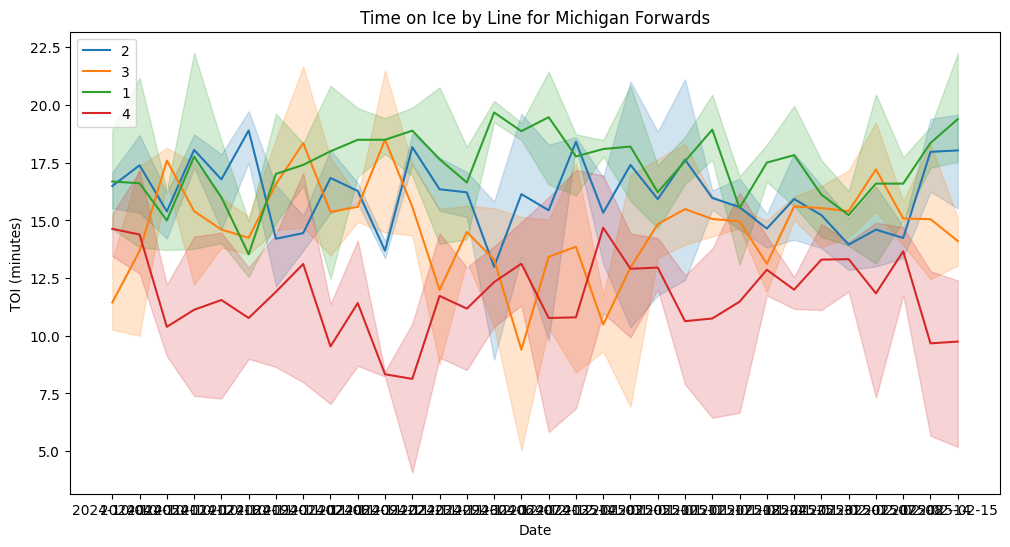

In [11]:
### Create a plot of TOI for Michigan State fowards over time grouped by line #
set_team = 'Michigan State'
set_team = 'Michigan'
# set_team = 'Minnesota'

# Set the figure size
plt.figure(figsize=(12, 6))

# Convert TOI column from seconds to minutes
merged_df['TOI'] = merged_df['TOI'] / 60

# Create a line plot for TOI over time for Michigan State forwards
for line in merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)
# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Forwards')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')




# plt.ylabel('TOI (seconds)')
# Show the plot
plt.show()
# Set the figure size




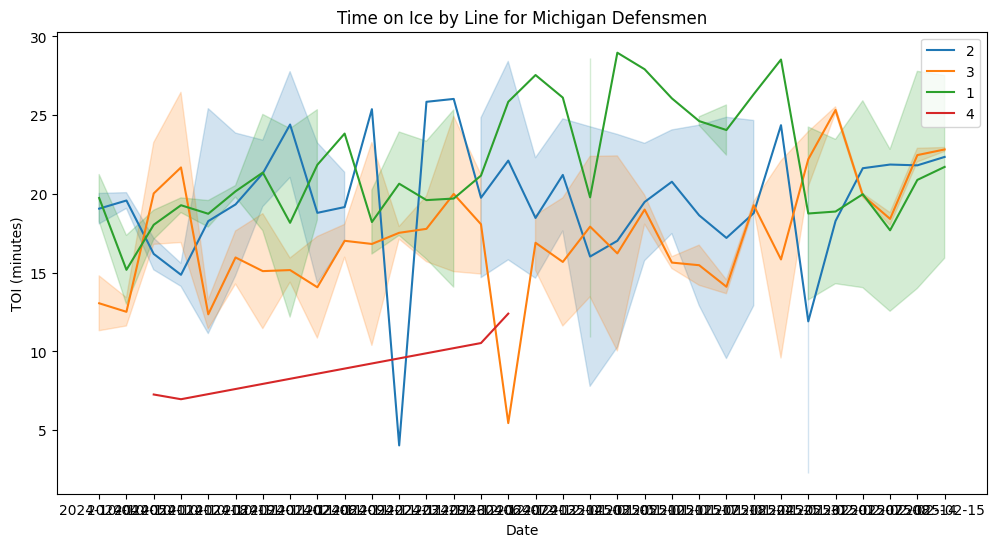

In [12]:
#### Defensive pairs time on ice Plot
# Set the figure size
plt.figure(figsize=(12, 6))

# Convert TOI column from seconds to minutes
# merged_df['TOI'] = merged_df['TOI'] / 60
# Create a line plot for TOI over time for Michigan State defensmen
for line in merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)

# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Defensmen')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')
# Show the plot
plt.show()
